In [ ]:
import numpy as np
import excipy
from excipy.processes import couplings_neighbours_fast, hopping_rate, add_exciton_random
from excipy.tools import *
from excipy.pbc import *
import matplotlib.pyplot as plt

In [19]:
from ase.data import covalent_radii
from ase.neighborlist import neighbor_list
from collections import deque, defaultdict


def robust_separate_atoms(atoms, scale=1.2):
    """Robust separation of molecules based on covalent radii and connectivity graph."""
    cutoffs = [covalent_radii[atom.number] * scale for atom in atoms]
    i, j = neighbor_list("ij", atoms, cutoffs)

    # Build undirected graph
    graph = defaultdict(set)
    for a, b in zip(i, j):
        graph[a].add(b)
        graph[b].add(a)

    visited = set()
    molecules = []

    for atom_idx in range(len(atoms)):
        if atom_idx in visited:
            continue
        queue = deque([atom_idx])
        group = []
        while queue:
            current = queue.popleft()
            if current in visited:
                continue
            visited.add(current)
            group.append(current)
            queue.extend(graph[current])
        molecules.append(atoms[group])

    return molecules


# =====
from ase.build.connected import connected_indices


def safe_separate(atoms, **kwargs):
    """Robust version of ase.build.separate that avoids ValueError when deleting np.int64."""
    indices = list(range(len(atoms)))

    separated = []
    while indices:
        my_indcs = connected_indices(atoms, indices[0], **kwargs)
        mol = Atoms(cell=atoms.cell, pbc=atoms.pbc)
        for i in my_indcs:
            i = int(i)  # Ensure Python int type
            mol.append(atoms[i])
            if i in indices:
                indices.remove(i)
        separated.append(mol)

    return separated


# =====
def original_separate(atoms, **kwargs):
    """Split atoms into separated entities

    Returns:
      List of Atoms object that connected_indices calls connected.
    """
    indices = list(range(len(atoms)))

    separated = []
    while indices:
        my_indcs = connected_indices(atoms, indices[0], **kwargs)
        separated.append(Atoms(cell=atoms.cell, pbc=atoms.pbc))
        for i in my_indcs:
            separated[-1].append(atoms[i])
            del indices[indices.index(i)]

    return separated


""" This happens because connected_indices() returns NumPy integers (np.int64),
    but the indices list is a Python-native list[int]. """

' This happens because connected_indices() returns NumPy integers (np.int64),\n    but the indices list is a Python-native list[int]. '

In [39]:
#FILENAME = "oct_no_org_mapbi3_10x10.cif"  # 'PR_clean.pdb'  #input geometry file, *supported formats: vasp, pdb, cif, xyz. NOTE: data should include lattice information!
FILENAME = "oct_no_org_mapbi3.cif"  # 'PR_clean.pdb'  #input geometry file, *supported formats: vasp, pdb, cif, xyz. NOTE: data should include lattice information!
#FILENAME = "PR_clean.pdb"  # input geometry file, *supported formats: vasp, pdb, cif, xyz. NOTE: data should include lattice information!

SUPERCELL = [10, 10, 1]  # whether you want to create a supercell
#SUPERCELL = [1, 1, 1]  # whether you want to create a supercell


CUTOFF = 2  # 20 # cut-off for interaction in A
mu0 = np.array([2.05634, -0.0297, -0.0109])  # Transition dipole moment in a.u.

for_cell = ase.io.read(FILENAME)  # getting molecule and cell information
s = for_cell.repeat(SUPERCELL)
print(SUPERCELL, "supercell created.")
print(f"s:{s}")
print(f"len(s):{len(s)}")


# print(my_indcs) from original_seperate: [0, np.int64(1), np.int64(2), np.int64(3), np.int64(3), np.int64(37), np.int64(362), np.int64(4), np.int64(40), np.int64(36), np.int64(360), np.int64(5), np.int64(6), np.int64(7), np.int64(366), np.int64(41), np.int64(42), np.int64(43), np.int64(77), np.int64(38), np.int64(39), np.int64(33), np.int64(398), np.int64(361), np.int64(363), np.int64(322), np.int64(397), np.int64(8), np.int64(44), np.int64(364), np.int64(80), np.int64(76), np.int64(32), np.int64(396), np.int64(320), np.int64(9), np.int64(10), np.int64(11), np.int64(370), np.int64(45), np.int64(46), np.int64(47), np.int64(365), np.int64(367), np.int64(326), np.int64(81), np.int64(82), np.int64(83), np.int64(117), np.int64(78), np.int64(79), np.int64(73), np.int64(34), np.int64(35), np.int64(29), np.int64(394), np.int64(399), np.int64(358), np.int64(393), np.int64(321), np.int64(323), np.int64(282), np.int64(357), np.int64(12), np.int64(48), np.int64(368), np.int64(84), np.int64(324), np.int64(120), np.int64(116), np.int64(72), np.int64(28), np.int64(392), np.int64(356), np.int64(280), np.int64(13), np.int64(14), np.int64(15), np.int64(374), np.int64(49), np.int64(50), np.int64(51), np.int64(369), np.int64(371), np.int64(330), np.int64(85), np.int64(86), np.int64(87), np.int64(325), np.int64(327), np.int64(286), np.int64(121), np.int64(122), np.int64(123), np.int64(157), np.int64(118), np.int64(119), np.int64(113), np.int64(74), np.int64(75), np.int64(69), np.int64(30), np.int64(31), np.int64(25), np.int64(390), np.int64(395), np.int64(354), np.int64(389), np.int64(359), np.int64(318), np.int64(353), np.int64(281), np.int64(283), np.int64(242), np.int64(317), np.int64(16), np.int64(52), np.int64(372), np.int64(88), np.int64(328), np.int64(124), np.int64(284), np.int64(160), np.int64(156), np.int64(112), np.int64(68), np.int64(24), np.int64(388), np.int64(352), np.int64(316), np.int64(240), np.int64(17), np.int64(18), np.int64(19), np.int64(378), np.int64(53), np.int64(54), np.int64(55), np.int64(373), np.int64(375), np.int64(334), np.int64(89), np.int64(90), np.int64(91), np.int64(329), np.int64(331), np.int64(290), np.int64(125), np.int64(126), np.int64(127), np.int64(285), np.int64(287), np.int64(246), np.int64(161), np.int64(162), np.int64(163), np.int64(197), np.int64(158), np.int64(159), np.int64(153), np.int64(114), np.int64(115), np.int64(109), np.int64(70), np.int64(71), np.int64(65), np.int64(26), np.int64(27), np.int64(21), np.int64(386), np.int64(391), np.int64(350), np.int64(385), np.int64(355), np.int64(314), np.int64(349), np.int64(319), np.int64(278), np.int64(313), np.int64(241), np.int64(243), np.int64(202), np.int64(277), np.int64(20), np.int64(56), np.int64(376), np.int64(92), np.int64(332), np.int64(128), np.int64(288), np.int64(164), np.int64(244), np.int64(200), np.int64(196), np.int64(152), np.int64(108), np.int64(64), np.int64(384), np.int64(348), np.int64(312), np.int64(276), np.int64(22), np.int64(23), np.int64(382), np.int64(57), np.int64(58), np.int64(59), np.int64(377), np.int64(379), np.int64(338), np.int64(93), np.int64(94), np.int64(95), np.int64(333), np.int64(335), np.int64(294), np.int64(129), np.int64(130), np.int64(131), np.int64(289), np.int64(291), np.int64(250), np.int64(165), np.int64(166), np.int64(167), np.int64(245), np.int64(247), np.int64(206), np.int64(201), np.int64(203), np.int64(237), np.int64(198), np.int64(199), np.int64(193), np.int64(154), np.int64(155), np.int64(149), np.int64(110), np.int64(111), np.int64(105), np.int64(66), np.int64(67), np.int64(61), np.int64(387), np.int64(346), np.int64(381), np.int64(351), np.int64(310), np.int64(345), np.int64(315), np.int64(274), np.int64(309), np.int64(279), np.int64(238), np.int64(273), np.int64(60), np.int64(380), np.int64(96), np.int64(336), np.int64(132), np.int64(292), np.int64(168), np.int64(248), np.int64(204), np.int64(236), np.int64(192), np.int64(148), np.int64(104), np.int64(344), np.int64(308), np.int64(272), np.int64(62), np.int64(63), np.int64(383), np.int64(342), np.int64(97), np.int64(98), np.int64(99), np.int64(337), np.int64(339), np.int64(298), np.int64(133), np.int64(134), np.int64(135), np.int64(293), np.int64(295), np.int64(254), np.int64(169), np.int64(170), np.int64(171), np.int64(249), np.int64(251), np.int64(210), np.int64(205), np.int64(207), np.int64(239), np.int64(233), np.int64(194), np.int64(195), np.int64(189), np.int64(150), np.int64(151), np.int64(145), np.int64(106), np.int64(107), np.int64(101), np.int64(347), np.int64(306), np.int64(341), np.int64(311), np.int64(270), np.int64(305), np.int64(275), np.int64(234), np.int64(269), np.int64(100), np.int64(340), np.int64(136), np.int64(296), np.int64(172), np.int64(252), np.int64(208), np.int64(232), np.int64(188), np.int64(144), np.int64(304), np.int64(268), np.int64(102), np.int64(103), np.int64(343), np.int64(302), np.int64(137), np.int64(138), np.int64(139), np.int64(297), np.int64(299), np.int64(258), np.int64(173), np.int64(174), np.int64(175), np.int64(253), np.int64(255), np.int64(214), np.int64(209), np.int64(211), np.int64(235), np.int64(229), np.int64(190), np.int64(191), np.int64(185), np.int64(146), np.int64(147), np.int64(141), np.int64(307), np.int64(266), np.int64(301), np.int64(271), np.int64(230), np.int64(265), np.int64(140), np.int64(300), np.int64(176), np.int64(256), np.int64(212), np.int64(228), np.int64(184), np.int64(264), np.int64(142), np.int64(143), np.int64(303), np.int64(262), np.int64(177), np.int64(178), np.int64(179), np.int64(257), np.int64(259), np.int64(218), np.int64(213), np.int64(215), np.int64(231), np.int64(225), np.int64(186), np.int64(187), np.int64(181), np.int64(267), np.int64(226), np.int64(261), np.int64(180), np.int64(260), np.int64(216), np.int64(224), np.int64(182), np.int64(183), np.int64(263), np.int64(222), np.int64(217), np.int64(219), np.int64(227), np.int64(221), np.int64(220), np.int64(223)]


[10, 10, 1] supercell created.
s:Atoms(symbols='I300Pb100', pbc=True, cell=[63.114999999999995, 63.114999999999995, 6.3161], spacegroup_kinds=...)
len(s):400


In [55]:
from ase.visualize import view
#s[0:4]
view(s)

<Popen: returncode: None args: ['/data/zj2433/miniconda3/bin/python', '-m', ...>

In [43]:
start = time()
# mol = separate_molecules_PBI(for_cell, SUPERCELL)
mol = ase.build.separate(s)   # separate Atoms into distinct molecules
# mol = robust_separate_atoms(s)
#mol = safe_separate(s)
print("System contains {} molecules.\n".format(len(mol)))
mol

ValueError: np.int64(3) is not in list

In [27]:

start = time()
# mol = separate_molecules_PBI(for_cell, SUPERCELL)
mol = ase.build.separate(s)   # separate Atoms into distinct molecules
#mol = robust_separate_atoms(s)
print("System contains {} molecules.\n".format(len(mol)))

Vol = s.get_volume() * 1e-12  # converting micrometr cube, match with experimental units

print("Volume: {:.3f} nm^3".format(Vol * 1e9))
print(
    "Lattice parameters [Å]:\n",
    for_cell.get_cell()[0],
    "\n",
    for_cell.get_cell()[1],
    "\n",
    for_cell.get_cell()[2],
    "\n",
)
t = time() - start
print(
    "Time for molecule separation: {} min {:.2f} s".format(
        int(t / 60), t - int(t / 60) * 60
    )
)

exc_conc = 370000  # excitons per micrometr cube, taken from experimental data

Vol = s.get_volume() * 1e-12  # converting micrometr cube, match with experimental units
print("Volume: {:.3f} nm^3".format(Vol * 1e9))
NUM_EXC = int(exc_conc * Vol) + 10
print(
    "Number of excitons required for {} value in experiment: {}".format(
        exc_conc, int(exc_conc * Vol)
    )
)

ValueError: np.int64(3) is not in list

In [ ]:
mol


[Atoms(symbols='I30000Pb10000', pbc=True, cell=[631.1500199999999, 631.1500199999999, 6.3161], spacegroup_kinds=...)]

In [ ]:
a = s.get_cell()[0, 0]
b = s.get_cell()[1, 1]
c = s.get_cell()[2, 2]


coords = []
for molecule in mol:
    coords.append(molecule.get_center_of_mass())
print(len(coords))

# mol = add_tdm(mu0, mol) # add rotated TDM to each molecule in the system

# neighbors, V = TDM_couplings_fast_PBC(molecules=mol, cutoff=20, box=(a,b,c))

# V_csr1 = csr_matrix(V, dtype=V.dtype)      # keeps only the non–zero entries
# print("dense aray :", V.shape, "   bytes:", V.nbytes / 1e6, "MB")
# print("sparse array   :", V.nnz,       "   bytes:", V.data.nbytes / 1e6, "MB")

1


In [17]:
from excipy.analysis import load_output_light

data = load_output_light("output.h5")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'output.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

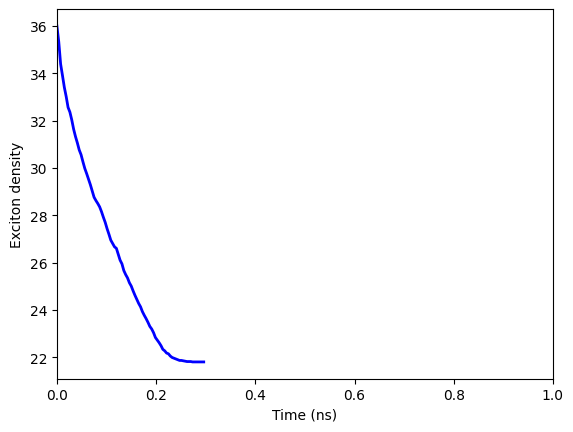

In [ ]:
from excipy.analysis import plot_average_exciton_population

plot_average_exciton_population(data, num_bins=80, x0=0, xf=0.8)
plt.xlim(0, 1)
# plt.ylim(0.001,46)
plt.savefig("exciton_density.png", bbox_inches="tight")

In [ ]:
t, exc = np.loadtxt("density.dat")
plt.figure(figsize=(5, 4))
plt.plot(t, exc, "b", linewidth=2)
plt.xlim(0, 1)
# plt.ylim(0,40)

NameError: name 'np' is not defined

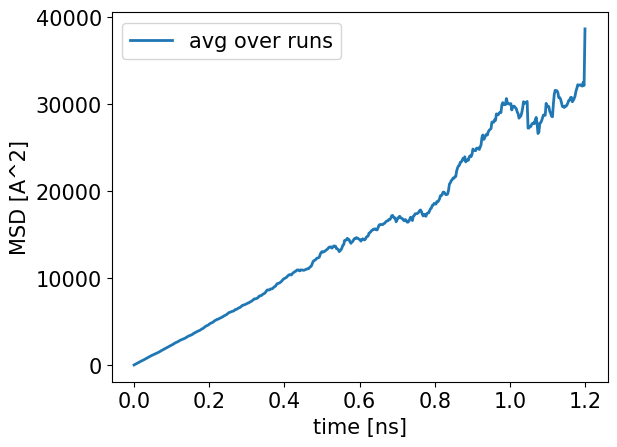

In [ ]:
t_grid, msd_avg = np.loadtxt("msd_avg.dat")
plt.plot(t_grid, msd_avg, lw=2, label="avg over runs")
plt.legend()
# plt.xlim(0, 0.2)
plt.ylabel("MSD [A^2]")
plt.xlabel("time [ns]")
plt.savefig("MSD_avg_over_runs.png", bbox_inches="tight")
plt.show()

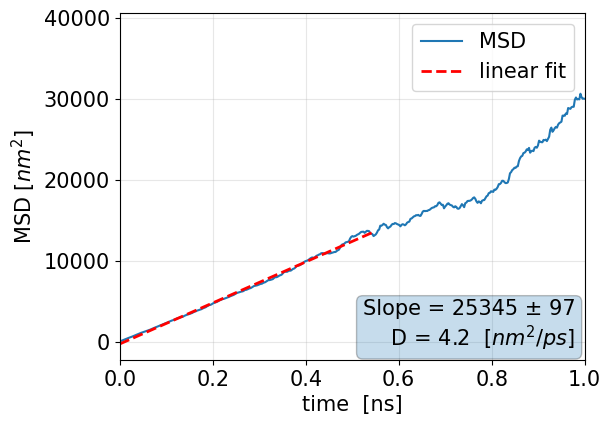

In [ ]:
from excipy.analysis import plot_msd_with_fit

plot_msd_with_fit(t_grid, msd_avg, t_min=0, t_max=0.55)
plt.xlim(0, 1)
plt.savefig("MSD_final.png", bbox_inches="tight")

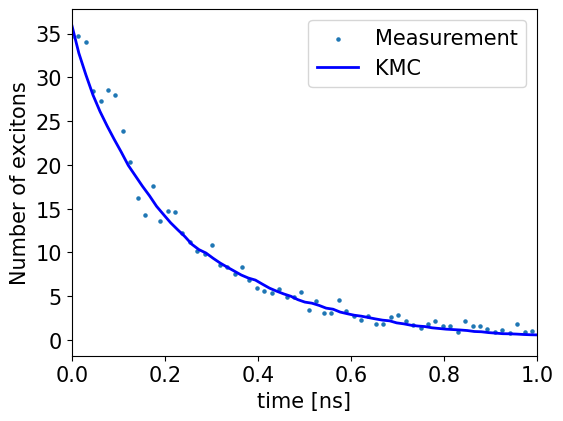

In [ ]:
t, exc = np.loadtxt("density.dat")
ex = np.loadtxt("KS_16_45deg_DL10000au_Bereich1_time.dat", unpack=True)
plt.figure(figsize=(6, 4.5))
plt.scatter(
    ex[0] - 2.93, ex[1] / max(ex[1]) * 36, linewidth=1, s=5, label="Measurement"
)
plt.plot(t, exc, "b", linewidth=2, label="KMC")
plt.xlim(0, 1)
plt.xlabel("time [ns]")
plt.ylabel("Number of excitons")
plt.legend()
plt.savefig("exciton_density.png", bbox_inches="tight")